## Problem 1a: 
## Periodic spinodal decomposition on a square domain

Necessary imports for graphing and PDE solving:

In [1]:
%matplotlib inline
import fipy as fp
import numpy as np
import matplotlib.pyplot as plt

The square domain of the problem has dimensions 20 units by 20 units, with cells that are half a unit long on each side. A PeriodicGrid2D object is used because the domain's boundary conditions are periodic.

In [2]:
mesh = fp.PeriodicGrid2D(nx=40, ny=40, dx=0.5, dy=0.5)

Constants and initial conditions:
$c_{\alpha}, c_{\beta},$ and $c_m = \frac{(c_{\alpha} + c_{\beta})}{2}$ are concentrations at which the bulk free energy has minima.
$\kappa$ is the gradient energy coefficient.

In [3]:
c_alpha = 0.05
c_beta = 0.95
c_m = (c_alpha + c_beta) / 2.
# control on height of double-well barrier
A = 2.0
kappa = 2.0

B = A / (c_alpha - c_m)**2
D = D_alpha = D_beta = 2. / (c_beta - c_alpha)

# initial conditions
c_0 = 0.45
q = np.sqrt((2., 3.))
epsilon = 0.01

$c_{var}$ is a cell variable specifying concentrations at various points in the mesh. Here, it is the solution variable:

$c_{var}\left(\vec{r}, t\right)$ such that

$$ c_{var}\left(\vec{r}, 0\right) = \bar{c}_0 + \epsilon \cos \left( \vec{q} \cdot \vec{r} \right) $$

In [4]:
# array of sample c-values: used in f versus c plot
vals = np.linspace(-.1, 1.1, 1000)

# setting up the concentration field
c_var = fp.CellVariable(mesh=mesh, name=r"$c$", hasOld=True)
r = np.array((mesh.x, mesh.y))
c_var[:] = c_0 + epsilon * np.cos((q[:, None] * r).sum(0))
# viewer = fp.Viewer(c_var, limits = {'ymin': 0, 'ymax': 20},
#                     datamin=.440, datamax =.460,
#                     title = "Matplot2DViewer test")

The equation for the bulk free energy density (alternatively called the chemical free energy density) of this system is expressed as 
$$ \int\limits_V{\!\Big(f_{chem}+\frac{\kappa}{2}{\big|\nabla c\big|}^2}\Big)\,\mathrm{d}V.$$ Also, $f_{chem}$ or $f_0$ in this problem has a simple polynomial form, $$ f_0  = -\frac{A}{2}(c-c_m)^2 +\frac{B}{4}(c-c_m)^4 + \frac{c_{\alpha}}{4}(c-c_{\alpha})^4 + \frac{c_{\beta}}{4}(c-c_{\beta})^4.$$

In [5]:
# bulk free energy density
def f_0(c):
    return - A / 2 * (c - c_m)**2 + B / 4 * (c - c_m)**4+ c_alpha / 4 * (c - c_alpha)**4 + c_beta / 4 * (c - c_beta)**4
# free energy
def f(c):
    return (f_0(c)+ .5*kappa*(c.grad.mag)**2)

# plot free energy density versus c
def plotf_c(c):
    plt.figure(1)
    plt.xlabel('c')
    plt.ylabel('f_0')
    plt.plot(vals, f(vals))
    plt.show()

Here, the elapsed time and total free energy at each time step are saved to separate lists. These lists are then updated in a text file.

In [6]:
# save elapsed time and free energy at each data point
f_data = []
time_data = []

def save_data(f, time):
    f_data.append(f.value)
    time_data.append(time)
    np.savetxt('free_energy.txt', zip(time_data, f_data))

The solver equation is now defined.

In [7]:
# start solver
eqn = fp.TransientTerm(coeff=1.) == fp.DiffusionTerm(D * f_0(c_var)) - fp.DiffusionTerm((D, kappa))

A time stepping scheme is used to solve the equation. If the residual increases, the solver backtracks; if the specified tolerance is not reached, the time step is recalculated.

In [17]:
elapsed = 0.0
steps = 0
dt = 0.01
total_sweeps = 2
tolerance = 1e-1
total_steps = 200

In [18]:
c_var.updateOld()
from fipy.solvers.pysparse import LinearLUSolver as Solver
solver = Solver()

Initialize an empty list for generated viewers:

In [19]:
viewers = []

In [ ]:
while steps < total_steps:
    res0 = eqn.sweep(c_var, dt=dt, solver=solver)
            
    for sweeps in range(total_sweeps):
        res = eqn.sweep(c_var, dt=dt, solver=solver)
        
#         print 'steps',steps
#         print 'res',res
#         print 'sweeps',sweeps
#         print 'dt',dt
        
    if res < res0 * tolerance:
        steps += 1
        elapsed += dt
        dt *= 1.1
        
# create 10 viewers to snapshot steps in the simulation
        if steps%(total_steps/10)==0:
            # record the volume integral of the free energy 
            save_data(f(c_var).cellVolumeAverage*mesh.numberOfCells, elapsed)
            # pickle the data on c as a function of space at this particular time
            fp.dump.write({'time' : elapsed, 'var': c_var}, '{0}{1}'.format(steps, ".pkl"))
            # create a viewer based on the pickled data
            viewers.append(fp.Viewer((fp.dump.read('{0}{1}'.format(steps, ".pkl"))['var']),
                        limits = {'ymin': 0.0, 'ymax': 20.0},
                        datamin=.440, datamax =.460,
                        title = '{0}{1}{2}'.format("t = ", '%.3f'%(elapsed), " s")))
        
        c_var.updateOld()
    else:
        dt *= 0.8
        c_var[:] = c_var.old

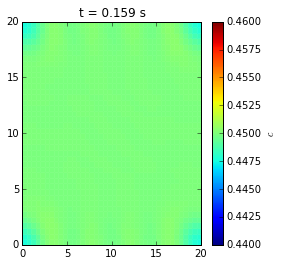

In [12]:
fp.MultiViewer(viewers).plot()

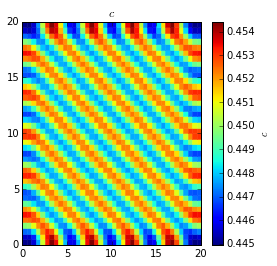

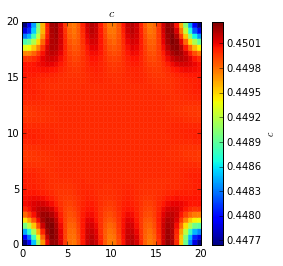

In [9]:
import fipy as fp
viewer = fp.Viewer(fp.dump.read('2.pkl')['var'])
viewer = fp.Viewer(fp.dump.read('{0}{1}'.format(steps, ".pkl"))['var'])

viewers.append(viewer)

In [10]:
?pickle.load()

Object `pickle.load` not found.


NameError: global name 'time_list' is not defined

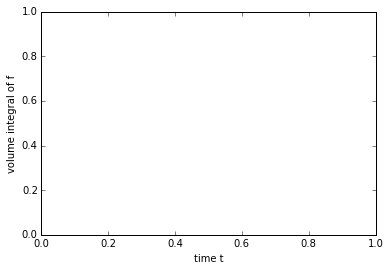

In [11]:
def plotf():
    plt.figure(1)
    plt.xlabel('time t')
    plt.ylabel('volume integral of f')
    plt.plot(time_list, f_list)
    plt.show()
plotf()

In [ ]:
plt.figure(2)

plt.subplot(411)
plt.subplot(412)
plt.subplot(413)
plt.subplot(414)

In [ ]:
energylist = np.loadtxt('free_energy.txt')

In [ ]:
!more free_energy.txt

In [ ]:
import fipy as fp

m = fp.Grid2D(nx=3, ny=3, dx=0.5, dy=2.0)
v = fp.CellVariable(mesh=m)
v[:] = [1, 2, 3, 4, 5, 6, 7, 8, 9]
print v
print v.grad
print v.grad.mag
print (v.grad[0]**2 + v.grad[1]**2)**0.5

In [ ]:
from fipy import *

m = fp.Grid2D(nx=40, ny=40, dx=0.5, dy=0.5)
x, y = m.cellCenters
xyVar = fp.CellVariable(mesh=m, name = "x y", value = x * y)
k = fp.Variable(name="k", value = 1.)
viewer = fp.Viewer(vars = fp.numerix.sin(k * xyVar),
                    limits = {'ymin': 0.1, 'ymax': 19.9},
                    datamin=-1.0, datamax =2.0,
                    title = "Matplot2DViewer test")

# for kval in range(10):
#     k.setValue(kval)
#     viewer.plot()

viewer1 = fp.Viewer(vars = fp.numerix.sin(2 * k * xyVar),
                    limits = {'ymin': 0.1, 'ymax': 19.9},
                    datamin=-0.9, datamax =2.0,
                    title = "Matplot2DViewer test")

MultiViewer([viewer, viewer1]).plot()




# r = np.array((m.x, m.y))

# array1 = []
# array2 = []
# array3 = []
# array4 = []

# for i in range(100):
#     array1.append(np.cos(r*i**2))
#     array2.append(r*np.sin(r*i-3))
#     array3.append(r*np.sqrt(np.absolute(np.sin(r*3*i)+np.cos(r*i+2))))
    
# viewer1 = fp.Viewer(array1)

In [ ]:
a = "{0} {1}".format(3.0,"hi")
print a

In [ ]:
import fipy as fp
fp.dump.write({'time' : 50.0, 'var': c_var}, 'test.pkl')

In [ ]:
thing = fp.dump.read('test.pkl')

In [ ]:
print type(thing['var'])

In [ ]:
thing['var'].mesh

In [ ]:
b = '{0}{1}'.format(steps, ".pkl")

print b